# Final Project - Yelp Location Classification
#### CSCI 3832 Natural Language Processing

Jupyter Notebook to load in the Yelp open dataset and classify reviews per state with LSTM. Runs validation scores and exports a copy of the model upon successful run.

In [38]:
# Necessary Imports

import os, random, sys, copy, re
import torch, torch.nn as nn, numpy as np
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize
from torch.nn.utils.rnn import pack_padded_sequence
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from nltk.corpus import stopwords

In [ ]:
# Load the dataset
reviews_by_state = pd.read_csv(
    "C:/Users/danie/Downloads/reviews_with_locations.csv.gz",   # Adjust the path as necessary
    compression='gzip',
    usecols=["text", "state"]
)

# Preview the data
reviews_by_state.head()

,text,state
0,"If you decide to eat here, just be aware it is...",PA
1,This is the second time we tried turning point...,PA
2,The place is cute and the staff was very frien...,PA
3,We came on a Saturday morning after waiting a ...,PA
4,"Mediocre at best. The decor is very nice, and ...",PA


In [ ]:
# Check the number of unique states in the dataset
reviews_by_state['state'].unique()

array(['PA', 'AZ', 'LA', 'CA', 'FL', 'IN', 'MO', 'TN', 'NV', 'NJ', 'IL',
       'ID', 'DE'], dtype=object)

In [ ]:
# Load the GloVe embeddings
glove_file = 'glove.6B/glove.6B.50d.txt' # modify to appropriate path for your file system

embeddings_dict = {}

with open(glove_file, 'r', encoding='utf8') as f:
    for i, line in enumerate(f):
        line = line.strip().split(' ')
        word = line[0]
        embed = np.asarray(line[1:], "float")

        embeddings_dict[word] = embed


print('Loaded {} words from glove'.format(len(embeddings_dict)))

low = -1.0 / 3
high = 1.0 / 3
embedding_matrix = np.random.uniform(low=low, high=high, size=(len(embeddings_dict)+1, 50))

word2id = {}
for i, word in enumerate(embeddings_dict.keys(), 1):

    word2id[word] = i                                
    embedding_matrix[i] = embeddings_dict[word]      

word2id['<pad>'] = 0

# Add <unk> token
word2id['unk'] = len(word2id)
embedding_matrix = np.vstack([
    embedding_matrix,
    np.random.uniform(low=low, high=high, size=(50,))
])

Loaded 400000 words from glove


In [ ]:
# Define the Dataset class
# this will create a dataset for the reviews by state and tokenize the text
class YelpReviewByStateDataset(Dataset):
    def __init__(self, csv_path=None, df=None, word2id=None, max_length=256, label_set=None, tokenizer=False):
        self.word2id = word2id
        self.max_length = max_length

        # Load data
        if df is not None:
            self.df = df.copy()
        else:
            self.df = pd.read_csv(csv_path, compression='gzip', usecols=['text', 'state'])

        self.texts = self.df["text"].tolist()
        self.labels = self.df["state"].tolist()

        if label_set:
            self.label_set = label_set
        else:
            self.label_set = sorted(list(set(self.labels)))

        self.label2id = {label: i for i, label in enumerate(self.label_set)}

        # Process tokenized data
        self.data = self.tokenize(self.texts, self.labels, tokenizer)

    def tokenize(self, texts, labels, tokenizer, remove_stopwords=True):
        print(f"Starting tokenization of {len(texts)} texts...")
        examples = []
        for i, (text, label) in enumerate(tqdm(zip(texts, labels), total=len(texts), desc="Tokenizing examples")):
            if tokenizer:
                tokens = word_tokenize(str(text).lower())
            else:
                tokens = str(text).lower().split()

            ids = [self.word2id.get(tok, self.word2id.get('unk', 0)) for tok in tokens]

            if len(ids) > self.max_length:
                ids = ids[:self.max_length]

            length = len(ids)

            if len(ids) < self.max_length:
                ids += [self.word2id.get('<pad>', 0)] * (self.max_length - len(ids))

            input_tensor = torch.tensor(ids)
            length_tensor = torch.tensor(length)

            examples.append(((input_tensor, length_tensor), self.label2id[label]))
        
        return examples

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

In [39]:
### Create Datasets

In [ ]:
# function to create a DataFrame sampler
def create_df_sampler(df=None, replacement=False, n_samples=50_000):

    sampled_dfs = [
        group.sample(n=n_samples, replace=replacement, random_state=50)
        for _, group in reviews_by_state.groupby('state')
    ]

    reviews_by_state_sampled = pd.concat(sampled_dfs).reset_index(drop=True)

    return reviews_by_state_sampled

In [ ]:
# function to prepare the datasets for training and validation
def prepare_yelp_datasets(
    reviews_df,
    word2id,
    test_size=0.2,
    random_state=50,
    tokenized=False
):

    # Split into train and validation
    train_df, valid_df = train_test_split(
        reviews_df,
        test_size=test_size,
        random_state=random_state,
        stratify=reviews_df['state']
    )

    # Consistent label set
    label_set = sorted(train_df['state'].unique())
    print("Creating training dataset...")


    train_dataset = YelpReviewByStateDataset(
        df=train_df,
        word2id=word2id,
        label_set=label_set,
        tokenizer=tokenized
    )

    valid_dataset = YelpReviewByStateDataset(
        df=valid_df,
        word2id=word2id,
        label_set=label_set,
        tokenizer=tokenized
    )


    return train_dataset, valid_dataset, label_set

In [ ]:
# predict function to evaluate the model
def predict(model, valid_dataloader, device='cpu'):
    model.eval()
    total_correct = 0
    total_examples = len(valid_dataloader.dataset)

    with torch.no_grad():
        for (x, x_lengths), y in valid_dataloader:
            x, x_lengths, y = x.to(device), x_lengths.to(device), y.to(device)

            logits = model(x, x_lengths)               # shape: (batch_size, num_classes)
            predictions = torch.argmax(logits, dim=1)  # shape: (batch_size,)

            total_correct += (predictions == y).sum().item()

    accuracy = total_correct / total_examples
    print('accuracy: {:.2f}%'.format(accuracy * 100))
    return accuracy

In [36]:
# Define the LSTM model
# this model will use the embedding matrix created from the GloVe embeddings and the LSTM layers to classify the reviews
class LSTMModel(nn.Module):

    def __init__(self, embedding_matrix, num_classes, lstm_hidden_size=50, num_lstm_layers=1, bidirectional=True):

        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.lstm = nn.LSTM(input_size = embedding_matrix.shape[1],
                            hidden_size = lstm_hidden_size,
                            num_layers = num_lstm_layers,
                            bidirectional = bidirectional,
                            batch_first = True)
        
        self.hidden_1 = nn.Linear(lstm_hidden_size * 2, lstm_hidden_size)
        self.hidden_2 = nn.Linear(lstm_hidden_size, num_classes)
        self.num_directions = 2 if bidirectional else 1
        self.relu = nn.ReLU()

    def forward(self, input_batch, input_lengths):
        embedded_input = self.embedding(input_batch)
        
        packed_input = pack_padded_sequence(embedded_input, input_lengths.cpu().long(), batch_first=True, enforce_sorted=False)

        packed_output, (hn, cn) = self.lstm(packed_input)

        hn_view = hn.view(self.lstm.num_layers, self.num_directions, input_batch.shape[0], self.lstm.hidden_size)
        hn_view_last_layer = hn_view[-1]

        hn_cat = torch.cat([hn_view_last_layer[-2, :, :], hn_view_last_layer[-1, :, :]], dim=1)

        hid = self.relu(self.hidden_1(hn_cat))
        output = self.hidden_2(hid)
        return output

In [ ]:
# training function for the LSTM model
# calculates training and validation loss and accuracy
def train_lstm_classification(model, train_dataset, valid_dataset, epochs=10, batch_size=32, learning_rate=0.001, print_frequency=25, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move model to the correct device
    model = model.to(device)

    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False)

    print('Total train batches: {}'.format(len(train_dataset) / batch_size))

    best_accuracy = 0.0
    best_model_sd = None
    all_losses = []

    for epoch in range(epochs):
        print(f'### Epoch: {epoch + 1} ###')
        model.train()
        avg_loss = 0

        for step, ((x, x_lengths), y) in enumerate(train_dataloader):
            # Move tensors to GPU
            x = x.to(device)
            x_lengths = x_lengths.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            output = model(x, x_lengths)  # output shape: (batch_size, num_classes)

            loss = criteria(output, y)
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()

            if step % print_frequency == (print_frequency - 1):
                avg_loss_value = avg_loss / print_frequency
                print(f'epoch: {epoch} batch: {step} loss: {avg_loss / print_frequency:.4f}')
                all_losses.append(avg_loss_value)
                avg_loss = 0

        print('Evaluating...')
        acc = predict(model, valid_dataloader, device=device)
        if acc > best_accuracy:
            best_model_sd = copy.deepcopy(model.state_dict())
            best_accuracy = acc

    return model.state_dict(), best_model_sd, all_losses


In [ ]:
# predict function to evaluate the model
def predict(model, valid_dataloader, device='cpu'):
    model.eval()
    total_correct = 0
    total_examples = len(valid_dataloader.dataset)

    with torch.no_grad():
        for (x, x_lengths), y in valid_dataloader:
            x, x_lengths, y = x.to(device), x_lengths.to(device), y.to(device)
            logits = model(x, x_lengths)
            predictions = torch.argmax(logits, dim=1)
            total_correct += (predictions == y).sum().item()

    accuracy = total_correct / total_examples
    print('accuracy: {:.2f}%'.format(accuracy * 100))
    return accuracy


In [ ]:
# Function to visualize the training and validation loss
def evaluate_model(model, dataset, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for (x, x_lengths), y in torch.utils.data.DataLoader(dataset, batch_size=128):
            x, x_lengths, y = x.to(device), x_lengths.to(device), y.to(device)

            logits = model(x, x_lengths)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=dataset.label_set)
    print(report)
    return report

In [ ]:
# Function to plot the confusion matrix
def plot_confusion_matrix(model, dataset, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for (x, x_lengths), y in torch.utils.data.DataLoader(dataset, batch_size=128):
            x, x_lengths, y = x.to(device), x_lengths.to(device), y.to(device)

            logits = model(x, x_lengths)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(dataset.label_set)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.label_set)
    disp.plot(cmap='viridis', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
# Function to train and save the model
# automatically saves the model after training
def train_and_save_model(training_data, run_name="model", tokenized=False, batch_size=128, epochs=4):    
    train_dataset, valid_dataset, label_set = prepare_yelp_datasets(
        reviews_df=training_data,
        word2id=word2id,
        tokenized=tokenized
    )

    print(len(train_dataset), "train samples")
    print(len(valid_dataset), "validation samples")
    print(train_dataset[0])  # (tensor, label_id)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = LSTMModel(embedding_matrix, num_classes=len(train_dataset.label_set))
    model_sd, best_model_sd, losses = train_lstm_classification(
        model, train_dataset, valid_dataset, batch_size=batch_size, epochs=epochs, device=device
    )

    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title("Training Loss Over Time")
    plt.xlabel("Logging Step")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    report = evaluate_model(model, valid_dataset, device=device)
    matrix = plot_confusion_matrix(model, valid_dataset, device=device)

    model_filename = f"{run_name}_tok{tokenized}_ep{epochs}.pt"
    torch.save(model.state_dict(), model_filename)
    print(f"Model saved to {model_filename}")

    return model, report, matrix


### Create test set and run the model

In [ ]:
# Adjust parameters for different runs
reviews_sampled = create_df_sampler(
    reviews_by_state, 
    n_samples=50_000, 
    replacement=False
)

Creating training dataset...
Starting tokenization of 2080000 texts...


Tokenizing examples:   0%|          | 0/2080000 [00:00<?, ?it/s]

Starting tokenization of 520000 texts...


Tokenizing examples:   0%|          | 0/520000 [00:00<?, ?it/s]

2080000 train samples
520000 validation samples
((tensor([    59,     80,      7,  31576,  12110,    761,      6, 400001,     50,
           193,   7447,   1222,    374,     42,    239,    193,     51,   2707,
         12110, 400001,   5910,      6,     27,    703,  16457,    262,      1,
         12110,   2856,     40,     33,    151,    192, 400001,  11459,      6,
        400001,   5910,    120,    193,  14540, 400001,     19,    120,     30,
          3536, 400001,     42, 400001,   2473,      5,    327,    138, 400001,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0

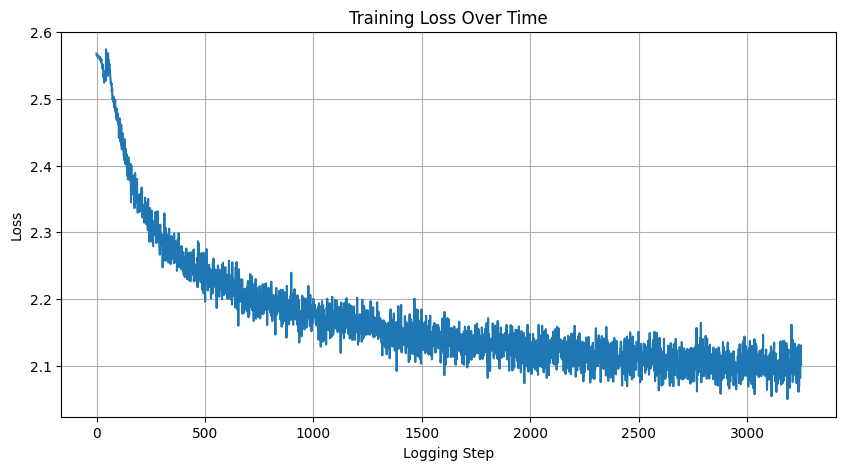

              precision    recall  f1-score   support

          AZ       0.43      0.17      0.25     40000
          CA       0.32      0.46      0.37     40000
          DE       0.25      0.23      0.24     40000
          FL       0.42      0.20      0.27     40000
          ID       0.34      0.19      0.25     40000
          IL       0.18      0.45      0.26     40000
          IN       0.25      0.23      0.24     40000
          LA       0.53      0.48      0.51     40000
          MO       0.36      0.19      0.25     40000
          NJ       0.22      0.26      0.24     40000
          NV       0.23      0.33      0.27     40000
          PA       0.23      0.28      0.25     40000
          TN       0.47      0.23      0.31     40000

    accuracy                           0.29    520000
   macro avg       0.33      0.29      0.28    520000
weighted avg       0.33      0.29      0.28    520000



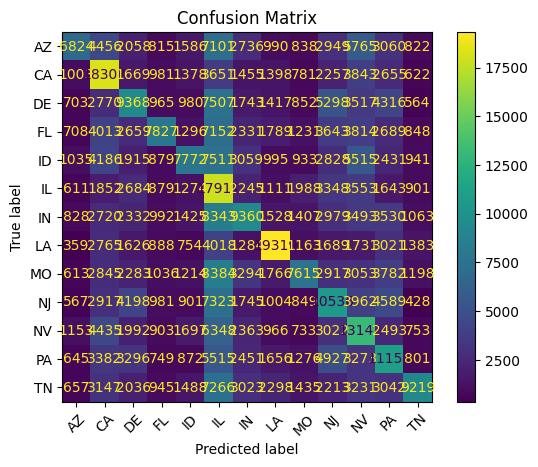

Model saved to lstm_200k_tokFalse_ep5.pt


In [ ]:
model, report, matrix = train_and_save_model(
    training_data=reviews_sampled,
    run_name="lstm_200k",   # adjust the name as necessary per run
    tokenized=False,
    batch_size=128,
    epochs=5
)